In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random
from nltk.tokenize.toktok import ToktokTokenizer
import nltk.data
from progressbar import ProgressBar
import random

In [8]:
#Get vocabulary of size N from OPUS 50k frequency list

def limit_opus_vocabulary(word_freq_file, size):
    with open(word_freq_file, 'r') as f:
        content = f.readlines()
    words = [x.strip().split(' ')[0] for x in content]
    word_freqs = [float(x.strip().split(' ')[1]) for x in content]
    
    vocab = []
    freqs = []
    for w, f in zip(words[0:size], word_freqs[0:size]):
        vocab.append(w)
        freqs.append(f)
        
    #normalize frequencies
    sum_freqs = sum(freqs)
    normalized_freqs = [f/sum_freqs for f in freqs]
    
    return vocab, normalized_freqs

/Applications/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


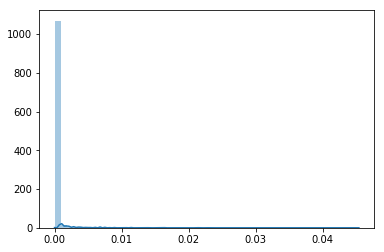

In [9]:
#Create vocabulary of top N frequent words
REFERENCE_VOCAB_SIZE = 5000
opus_reduced_vocab, opus_reduced_freqs = limit_opus_vocabulary('src/opus_en_50k.txt', REFERENCE_VOCAB_SIZE)
opus_reduced_vocab_dict = {w:opus_reduced_freqs[i] for i, w in enumerate(opus_reduced_vocab)}

#frequency plot on the opus vocabulary
ax = sns.distplot(np.asarray(opus_reduced_freqs))

In [12]:
#Tatoeba filtering
with open('etc/boynames.txt', 'r') as f:
    boynames = f.readlines()
    boynames = [name[0:-1] for name in boynames]
with open('etc/girlnames.txt', 'r') as f:
    girlnames = f.readlines()
    girlnames = [name[0:-1] for name in girlnames]
with open('etc/avoidlist.txt', 'r') as f:
    avoidlist = f.readlines()
    avoidlist = [word[0:-1] for word in avoidlist]
    
MAX_COMMAS = 9
MAX_PERIOD = 6
    
def filter_tatoeba(sent_ids, sents, max_tokens, tom_replacement_set, mary_replacement_set, avoid_set = []):
    filtered_ids = []
    filtered_sents = []
    filtered_sent_tokens = []
    
    pbar = ProgressBar()
    for index in pbar(range(len(sent_ids))):
        sent_id = sent_ids[index]
        sent = sents[index]
        sent_tokens = tokenize_en(sent, True, True)
        if len(sent_tokens) <= max_tokens and sent_tokens.count(',') < MAX_COMMAS and sent_tokens.count('.') < MAX_PERIOD and len(intersection(avoidlist,sent_tokens)) == 0:
            clean_sent = sent
            #Name replacement - tatoeba corpus has an intense use of these two names
            if 'tom' in sent_tokens:
                clean_sent = clean_sent.replace('Tom', tom_replacement_set[random.randint(0,len(tom_replacement_set) - 1)])
            if 'mary' in sent_tokens:
                clean_sent = clean_sent.replace('Mary', mary_replacement_set[random.randint(0,len(mary_replacement_set) - 1)])
                
            filtered_sents.append(clean_sent)
            filtered_ids.append(int(sent_id))
            filtered_sent_tokens.append(sent_tokens)
            
    return filtered_sents, filtered_sent_tokens, filtered_ids

def filter_selected_sents(sents, ids, skip_sent_ids):
    filtered_sents = []
    filtered_ids = []
    for i, s in zip(ids, sents):
        if i not in skip_sent_ids:
            filtered_sents.append(clean_sent)
            filtered_ids.append(sent_id)
    return filtered_sents, filtered_ids
    
#Tokenization and vocab building tools
tokenizer_en = nltk.data.load('tokenizers/punkt/english.pickle')
toktok = ToktokTokenizer()

def tokenize_en(string, to_lower = False, clear_nonalpha = False):
    tokens = []
    if to_lower:
        string = string.lower()
    string = string.strip()

    for sent in tokenizer_en.tokenize(string):
        if clear_nonalpha:
            sent_tokens = [tok for tok in toktok.tokenize(sent) if tok.isalpha()]
        else:
            sent_tokens = [tok for tok in toktok.tokenize(sent)]
        
        tokens.extend(sent_tokens)
    return tokens

def get_vocabulary_from_corpus(sentence_tokens):
    vocab_dict = {}
    total_words = 0
    for tokens in sentence_tokens:
        word_tokens = [tok for tok in tokens if tok.isalpha()]
        for word_token in word_tokens:
            if word_token in vocab_dict:
                vocab_dict[word_token] += 1
            else:
                vocab_dict[word_token] = 1
            total_words += 1
                
    sorted_vocab, sorted_freqs = sort_lists_wrt_list(list(vocab_dict.keys()), list(vocab_dict.values()))

    #normalize frequencies 
    #sum_freqs = sum(sorted_freqs)
    normalized_freqs = [float(f)/float(total_words) for f in sorted_freqs]
    
    print("Total #words:", total_words)
    
    return sorted_vocab, normalized_freqs, total_words

def sort_lists_wrt_list(mylist, values, ascending=False):
    mylist_array = np.array(mylist)
    values_array = np.array(values)  
    
    if ascending:
        inds = values_array.argsort()[::]
    else:
        inds = values_array.argsort()[::-1]
    
    mylist_sorted = mylist_array[inds]
    values_sorted = values_array[inds]
    
    return list(mylist_sorted), list(values_sorted)

def sort_multilists_wrt_list(mylists, values, ascending=False):
    mylists_arrays = [np.array(mylist) for mylist in mylists]
    values_array = np.array(values)  
    
    if ascending:
        inds = values_array.argsort()[::]
    else:
        inds = values_array.argsort()[::-1]
    
    mylists_sorted = [mylist_array[inds] for mylist_array in mylists_arrays]
    values_sorted = values_array[inds]
    
    return [list(mylist_sorted) for mylist_sorted in mylists_sorted], list(values_sorted)

def shuffle_parallel_lists(list_of_lists):
    list_of_arrays = [np.array(l) for l in list_of_lists]
    inds = list(range(0, len(list_of_arrays[0])))
    random.shuffle(inds)
    return [list(l[inds]) for l in list_of_arrays]

def intersection(lst1, lst2): 
    lst3 = [value for value in lst1 if value in lst2] 
    return list(set(lst3))

def difference(lst1, lst2):
    lst3 = [value for value in lst1 if value not in lst2] 
    return list(set(lst3))

In [14]:
#Read source set
tatoeba_corpus_path = "src/tatoeba_sentences_EN.csv"
with open(tatoeba_corpus_path, 'r') as f:
    content = f.readlines()
    
all_tatoeba_sent_info = [[x.strip().split("\t")[0], x.strip().split("\t")[2]] for x in content]
all_tatoeba_sent_ids = [i[0]for i in all_tatoeba_sent_info]
all_tatoeba_sents = [i[1]for i in all_tatoeba_sent_info]
print('all tatoeba', len(all_tatoeba_sents))

all tatoeba 1196198


In [15]:
#Clean the source set
MAX_TOKENS = 40
clean_tatoeba_sents, clean_tatoeba_sent_tokens, clean_tatoeba_ids = filter_tatoeba(all_tatoeba_sent_ids, 
                                                                                   all_tatoeba_sents, 
                                                                                   MAX_TOKENS, 
                                                                                   boynames, 
                                                                                   girlnames, 
                                                                                   avoidlist)

print('clean tatoeba', len(clean_tatoeba_sents))

clean tatoeba 1190776


In [16]:
#Read exclude sets
exclude_set_files = ['etc/exclude.txt']
exclude_set = []
for file in exclude_set_files:
    to_exclude = []
    with open(file, 'r') as f:
        lines = f.readlines()
        to_exclude = [int(idx[0:-1]) for idx in lines]
    exclude_set.extend(to_exclude)

#Sort it
exclude_set, _ = sort_lists_wrt_list(exclude_set, exclude_set, ascending=True)

In [17]:
#Filter previously stored sentences (exclude_set)
print('all set size', len(clean_tatoeba_ids))
print('exclude set size', len(exclude_set))

filtered_tatoeba_sents = []
filtered_tatoeba_sent_tokens = []
filtered_tatoeba_ids = []

all_pointer = 0
exclude_pointer = 0

while all_pointer < len(clean_tatoeba_ids):
    all_id = clean_tatoeba_ids[all_pointer]
    if exclude_pointer == len(exclude_set): #already at the end of exclude set take the rest from all set
        filtered_tatoeba_sents.append(clean_tatoeba_sents[all_pointer])
        filtered_tatoeba_sent_tokens.append(clean_tatoeba_sent_tokens[all_pointer])
        filtered_tatoeba_ids.append(clean_tatoeba_ids[all_pointer])
        
        all_pointer += 1
    else:
        exclude_id = exclude_set[exclude_pointer]
        while all_id < exclude_id:
            filtered_tatoeba_sents.append(clean_tatoeba_sents[all_pointer])
            filtered_tatoeba_sent_tokens.append(clean_tatoeba_sent_tokens[all_pointer])
            filtered_tatoeba_ids.append(clean_tatoeba_ids[all_pointer])

            all_pointer += 1
            all_id = clean_tatoeba_ids[all_pointer]

        all_pointer += 1
        exclude_pointer += 1

print('filtered tatoeba', len(filtered_tatoeba_sents))

all set size 1190776
exclude set size 5000
filtered tatoeba 1185776


In [18]:
#Naive corpus selection: Select C random sentences
CORPUS_SIZE = 10000
shuffled_sents, shuffled_sent_tokens, shuffled_ids = shuffle_parallel_lists([filtered_tatoeba_sents, filtered_tatoeba_sent_tokens, filtered_tatoeba_ids])

naive_corpus_sents = shuffled_sents[0:CORPUS_SIZE]
naive_corpus_sent_tokens = shuffled_sent_tokens[0:CORPUS_SIZE]
naive_corpus_ids = shuffled_ids[0:CORPUS_SIZE]

In [19]:
#Build vocabulary on the corpus
corpus = naive_corpus_sents
corpus_tokenized = naive_corpus_sent_tokens
reference_vocab = opus_reduced_vocab

corpus_vocab, corpus_freqs, corpus_total_words = get_vocabulary_from_corpus(corpus_tokenized)

intersecting_vocab = intersection(reference_vocab, corpus_vocab)
missing_vocab = difference(reference_vocab, corpus_vocab)
extra_vocab = difference(corpus_vocab, reference_vocab)

print("corpus size", len(corpus))
print("corpus_vocab", len(corpus_vocab))
print("reference vocab", len(reference_vocab))
print("intersecting", len(intersecting_vocab))
print("missing", len(missing_vocab))
print("extra", len(extra_vocab))
print("%f"%(len(missing_vocab)/len(reference_vocab) * 100))

Total #words: 79181
corpus size 10000
corpus_vocab 6169
reference vocab 5000
intersecting 3297
missing 1703
extra 2872
34.060000


In [ ]:
#NOT USED
#Word frequency difference analysis
freq_differences_word = []
freq_differences_diff = []
for w_corpus, f_corpus in zip(corpus_vocab, corpus_freqs):
    try:
        f_reference = opus_freqs[opus_vocab.index(w_corpus)]
        #print("%s - f_corp=%f, f_ref=%f"%(w_corpus, f_corpus, f_reference))
        freq_difference = f_reference - f_corpus
        freq_differences_word.append(w_corpus)
        freq_differences_diff.append(freq_difference)
    except:
        f_reference = 0

freq_differences_word_array = np.array(freq_differences_word)
freq_differences_diff_array = np.array(freq_differences_diff)
inds = freq_differences_diff_array.argsort()[::-1]
    
sorted_freq_differences_word = freq_differences_word_array[inds]
sorted_freq_differences_diff = freq_differences_diff_array[inds]

In [ ]:
#NOT USED
#Word frequency difference analysis - continued
threshold = 0.001
for i, (w, d) in enumerate(zip(sorted_freq_differences_word, sorted_freq_differences_diff)):
    opus_freq = opus_freqs[opus_vocab.index(w)]
    need = int(float(corpus_total_words) * d)
    if d >= threshold or d <= (-1* threshold):
        print("%d: %s - diff:%f, need:%d"%(i, w, d, need))

In [ ]:
#Print out missing words in the order that they appear in opus vocabulary
missing_indexes = [opus_vocab.index(w) for w in still_missing_vocab]
sorted_missing_vocab, sorted_missing_index = sort_lists_wrt_list(missing_vocab, missing_indexes, True)

for w, index in zip(sorted_missing_vocab, sorted_missing_index):
    print("%s - opus ind:%i"%(w, index))

In [20]:
#Take out sentences in the corpus: those with non-frequent words and randomly
RANDOM_SENTENCE_TAKEOUT = 4 #size of die to roll, put -1 to skip
count = 0
naive_corpus_sents_nonfrequent_takenout = []
naive_corpus_ids_nonfrequent_takenout = []
naive_corpus_senttokens_nonfrequent_takenout = []
for sent, sent_tokens, sent_id in zip(naive_corpus_sents, naive_corpus_sent_tokens, naive_corpus_ids):
    nonfrequent = False
    for token in sent_tokens:
        if token not in opus_reduced_vocab: #condition for non-frequent = not in opus_reduced_vocab
            nonfrequent = True
            break
            
    #Random sentence extraction
    if not RANDOM_SENTENCE_TAKEOUT == -1:
        dice = random.randint(0,RANDOM_SENTENCE_TAKEOUT)
    else:
        dice = 1

    if not dice == 0:        
        if nonfrequent:
            count += 1
        else:
            naive_corpus_sents_nonfrequent_takenout.append(sent)
            naive_corpus_ids_nonfrequent_takenout.append(sent_id)
            naive_corpus_senttokens_nonfrequent_takenout.append(sent_tokens)

#Build vocabulary on the corpus
corpus = naive_corpus_sents_nonfrequent_takenout
corpus_tokenized = naive_corpus_senttokens_nonfrequent_takenout
reference_vocab = opus_reduced_vocab

reduced_corpus_vocab, reduced_corpus_freqs, reduced_corpus_total_words = get_vocabulary_from_corpus(corpus_tokenized)

intersecting_vocab = intersection(reference_vocab, reduced_corpus_vocab)
missing_vocab = difference(reference_vocab, reduced_corpus_vocab)
extra_vocab = difference(reduced_corpus_vocab, reference_vocab)

print("corpus size", len(corpus))
print("corpus_vocab", len(corpus_vocab))
print("reference vocab", len(reference_vocab))
print("intersecting", len(intersecting_vocab))
print("missing", len(missing_vocab))
print("extra", len(extra_vocab))
print("%f"%(len(missing_vocab)/len(reference_vocab) * 100))

Total #words: 43559
corpus size 5633
corpus_vocab 6169
reference vocab 5000
intersecting 2478
missing 2522
extra 0
50.440000


In [22]:
#Search in rest of the sentences in tatoeba which has the missing words
missing_vocab_replacement_coefs = [(REFERENCE_VOCAB_SIZE - opus_reduced_vocab.index(token))/1000 if token in missing_vocab else 0.0 for token in opus_reduced_vocab]
original_missing_vocab_replacement_coefs = missing_vocab_replacement_coefs.copy()

count = 0 
no_missing_in_candidate = []
candidate_replacement_score = []
candidate_sent_index = []
candidate_missing_word_indexes = []
candidate_missing_word_coefs = []
pbar = ProgressBar()
for i in pbar(range(len(filtered_tatoeba_sents))):
    if i < CORPUS_SIZE:
        continue
        
    sent = filtered_tatoeba_sents[i]    
    sent_tokens = filtered_tatoeba_sent_tokens[i]
    missing_in_sent = intersection(sent_tokens, missing_vocab)
    no_missing = len(missing_in_sent)
    extra_in_sent = difference(sent_tokens, opus_reduced_vocab)
    no_extra = len(extra_in_sent)

    
    missing_word_indexes = [opus_reduced_vocab.index(token) for token in missing_in_sent]
    missing_word_replacement_coefs = [missing_vocab_replacement_coefs[token_index] for token_index in missing_word_indexes]    
    replacement_score = sum(missing_word_replacement_coefs)
    
    
    if no_missing > 0 and no_extra == 0 :
        no_missing_in_candidate.append(no_missing)
        candidate_replacement_score.append(replacement_score)
        candidate_sent_index.append(i)
        candidate_missing_word_indexes.append(missing_word_indexes)
        candidate_missing_word_coefs.append(missing_word_replacement_coefs)
        count += 1
    
[candidate_sent_index_sorted, candidate_missing_word_coefs_sorted, candidate_missing_word_indexes_sorted], candidate_replacement_score_sorted = sort_multilists_wrt_list([candidate_sent_index, candidate_missing_word_coefs, candidate_missing_word_indexes], candidate_replacement_score)    
        
print("no candidate fill-in sents", len(candidate_sent_index_sorted))

100% |########################################################################|


no candidate fill-in sents 110313


In [ ]:
#To restore original coefficients before rescoring
missing_vocab_replacement_coefs = original_missing_vocab_replacement_coefs.copy()

In [23]:
#Rescore candidates. Replacement coefficient of a missing word is reduced by once it is seen. 
new_candidate_replacement_score = []
new_candidate_missing_word_coefs = []
for candidate_score, candidate_sent, covered_indexes in zip(candidate_replacement_score_sorted, candidate_sent_index_sorted, candidate_missing_word_indexes_sorted):

    new_missing_word_replacement_coefs = [missing_vocab_replacement_coefs[token_index] for token_index in covered_indexes]
    new_replacement_score = sum(new_missing_word_replacement_coefs)
    new_candidate_missing_word_coefs.append(new_missing_word_replacement_coefs)
    new_candidate_replacement_score.append(new_replacement_score)
    
    #Reduce coef of less frequent words more than frequent words in order to maintain frequency
    for token_index in covered_indexes:
        if token_index < 1000:
            missing_vocab_replacement_coefs[token_index] -= missing_vocab_replacement_coefs[token_index]*50/100
        elif token_index < 2000:
            missing_vocab_replacement_coefs[token_index] -= missing_vocab_replacement_coefs[token_index]*60/100
        elif token_index < 2000:
            missing_vocab_replacement_coefs[token_index] -= missing_vocab_replacement_coefs[token_index]*70/100
        elif token_index < 3000:
            missing_vocab_replacement_coefs[token_index] -= missing_vocab_replacement_coefs[token_index]*80/100
        elif token_index < 4000:
            missing_vocab_replacement_coefs[token_index] -= missing_vocab_replacement_coefs[token_index]*90/100
        elif token_index < 5000:
            missing_vocab_replacement_coefs[token_index] -= missing_vocab_replacement_coefs[token_index]*100/100
        elif token_index < 6000:
            missing_vocab_replacement_coefs[token_index] -= missing_vocab_replacement_coefs[token_index]*100/100
        elif token_index < 7000:
            missing_vocab_replacement_coefs[token_index] -= missing_vocab_replacement_coefs[token_index]*100/100


[new_candidate_sent_index_sorted, new_candidate_missing_word_coefs_sorted, new_candidate_missing_word_indexes_sorted], new_candidate_replacement_score_sorted = sort_multilists_wrt_list([candidate_sent_index_sorted, candidate_missing_word_coefs_sorted, candidate_missing_word_indexes_sorted], new_candidate_replacement_score)    

In [ ]:
#print replacement candidate sentences sorted with their score sum

# sentence_index = candidate_sent_index_sorted
# sentence_coefs = candidate_missing_word_coefs_sorted
# sentence_missing_words = candidate_missing_word_indexes_sorted
# sentence_score = candidate_replacement_score_sorted

sentence_index = new_candidate_sent_index_sorted
sentence_coefs = new_candidate_missing_word_coefs_sorted
sentence_missing_words = new_candidate_missing_word_indexes_sorted
sentence_score = new_candidate_replacement_score_sorted

count = 0
no_fill_in = CORPUS_SIZE - len(naive_corpus_sents_nonfrequent_takenout)
for s_index, s_score, missing_words, coefs in zip(sentence_index, sentence_score, sentence_missing_words, sentence_coefs):
    missing_info=""
    for token_index, coef in zip(missing_words, coefs):
        missing_info += opus_reduced_vocab[token_index]
        missing_info += "("
        missing_info += str(token_index)
        missing_info += "/"
        missing_info += str(coef)
        missing_info += ") "
    
    if no_fill_in - count <= 0:
        print("=========================================================")
    
    print("%s -- %f %s"%(filtered_tatoeba_sents[s_index], s_score, missing_info))
    count += 1

In [ ]:
#Check duplication in fill-in set
fillin_from = new_candidate_sent_index_sorted
fillin_from_tokens = [filtered_tatoeba_sent_tokens[index] for index in new_candidate_sent_index_sorted]

cover_dict = {missing_word:0 for missing_word in missing_vocab}
for sent_tokens in fillin_from_tokens:
    for tok in sent_tokens:
        if tok in cover_dict.keys():
            cover_dict[tok] += 1
            if cover_dict[tok] > 1:
                print("%s is covered %i times"%(tok, cover_dict[tok]))

In [25]:
#Fill in candidate sentences to the reduced corpus

fillin_from = new_candidate_sent_index_sorted
fillin_from_tokens = [filtered_tatoeba_sent_tokens[index] for index in new_candidate_sent_index_sorted]

naive_corpus_sents_frequent_filledin = naive_corpus_sents_nonfrequent_takenout.copy()
naive_corpus_senttokens_frequent_filledin = naive_corpus_senttokens_nonfrequent_takenout.copy()
naive_corpus_ids_frequent_filledin = naive_corpus_ids_nonfrequent_takenout.copy()
print("reduced corpus", len(naive_corpus_sents_nonfrequent_takenout))
for sent_index in new_candidate_sent_index_sorted:
    sent = filtered_tatoeba_sents[sent_index]
    sent_id = filtered_tatoeba_ids[sent_index]
    sent_tokens = filtered_tatoeba_sent_tokens[sent_index]
    naive_corpus_sents_frequent_filledin.append(sent)
    naive_corpus_senttokens_frequent_filledin.append(sent_tokens)
    naive_corpus_ids_frequent_filledin.append(sent_id)
    if len(naive_corpus_sents_frequent_filledin) >= CORPUS_SIZE:
        break
print("filled-in corpus", len(naive_corpus_sents_frequent_filledin))

reduced corpus 5633
filled-in corpus 10000


In [26]:
#Filled-in corpus stats
corpus = naive_corpus_sents_frequent_filledin
corpus_tokens = naive_corpus_senttokens_frequent_filledin
reference_vocab = opus_reduced_vocab

modified_corpus_vocab, modified_corpus_freqs, modified_corpus_total_words = get_vocabulary_from_corpus(corpus_tokens)

intersecting_vocab = intersection(reference_vocab, modified_corpus_vocab)
still_missing_vocab = difference(reference_vocab, modified_corpus_vocab)
still_extra_vocab = difference(modified_corpus_vocab, reference_vocab)

print("corpus size", len(corpus))
print("corpus_vocab", len(modified_corpus_vocab))
print("reference vocab", len(reference_vocab))
print("intersecting", len(intersecting_vocab))
print("still missing", len(still_missing_vocab))
print("still extra", len(still_extra_vocab))
print("%f"%(len(still_missing_vocab)/len(reference_vocab) * 100))

Total #words: 85140
corpus size 10000
corpus_vocab 4809
reference vocab 5000
intersecting 4809
still missing 191
still extra 0
3.820000


In [28]:
#Write corpus to file (run after doing counts)

CORPUS_ID = 'testcore/testcore'
corpus_sents_to_write = naive_corpus_sents_frequent_filledin
corpus_ids_to_write = naive_corpus_ids_frequent_filledin

with open(CORPUS_ID +'_sentences.txt', 'w') as f:
    for s in corpus_sents_to_write:
        f.write(s + "\n")
        
with open(CORPUS_ID +'_ids.txt', 'w') as f:
    for s in corpus_ids_to_write:
        #print(type(s))
        f.write(str(s) + "\n")
    
with open(CORPUS_ID +'_vocab.txt', 'w') as f:
    for s in corpus_vocab:
        f.write(s + "\n")
        
with open(CORPUS_ID +'_missingvocab.txt', 'w') as f:
    for s in missing_vocab:
        f.write(s + "\n")